The file Cepheids_DATA_errMVerrP.csv contains the data we have used in class for a sample
of Cepheids variable stars. Specifically, the columns in the files are:

• MV: absolute magnitude in the V band
• MV_err: error on the absolute magnitude
• LogP: logarithm of the pulsations period
• LogP_err: error on the logarithm of the period

Write a Bayesian linear regression model that neglects observational errors, and implement
it in PyMC. Analyze the results, and summarize your model with your best estimate for the
parameters and their uncertainty.
Overplot your best-fit line with the 95% credibility region on the data.
You realize, by looking at the data, that your slope may be affected by the presence of a couple
of outliers. Write a Bayesian Mixture model that account for the possibility that some of the
observations are not generated by the same generative process.

In [14]:
#Import Packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
from sklearn.linear_model import LinearRegression
import arviz as az
from astropy.io import ascii


In [15]:
#Reading in the data
df = pd.read_csv("/Users/abbystokes/Documents/GitHub/AST5731/Activity 12/Cepheids_DATA_errMVerrP (1).csv")

In [16]:
#Visual Inspection
df.head()


,MV,MV_err,LogP,LogP_err
0,1.25,0.50,0.17,0.07
1,5.20,0.60,0.05,0.01
2,-1.58,0.15,0.42,0.02
3,-1.93,0.13,0.42,0.07
4,-2.21,0.12,0.69,0.02


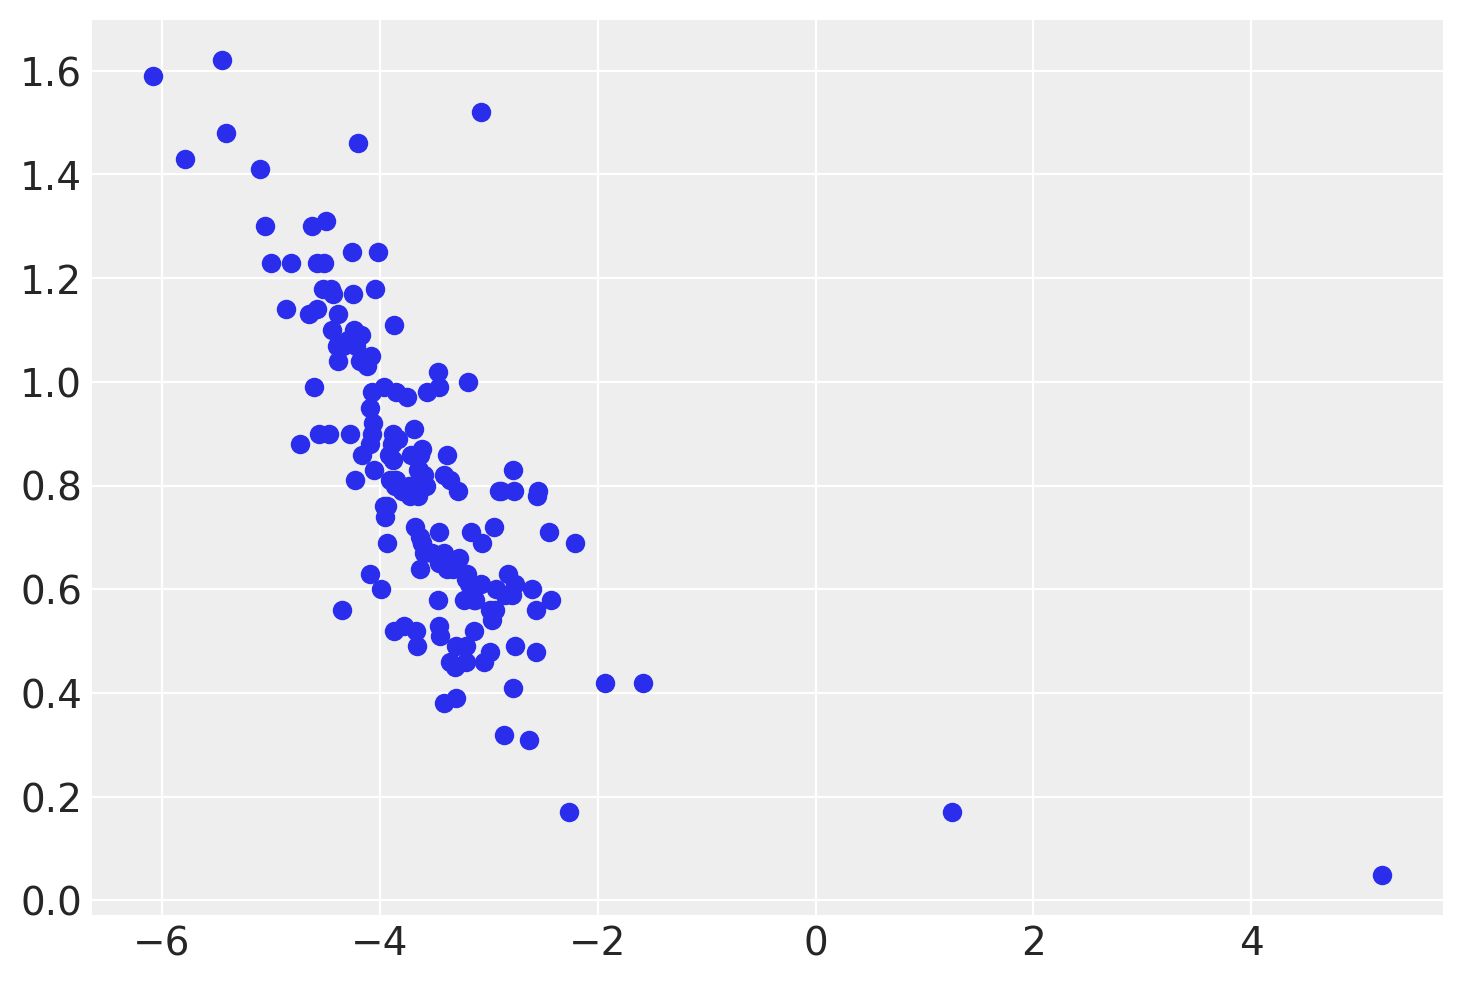

In [25]:
plt.scatter(df['MV'],df['LogP'])

array([[<Axes: title={'center': 'MV'}>]], dtype=object)

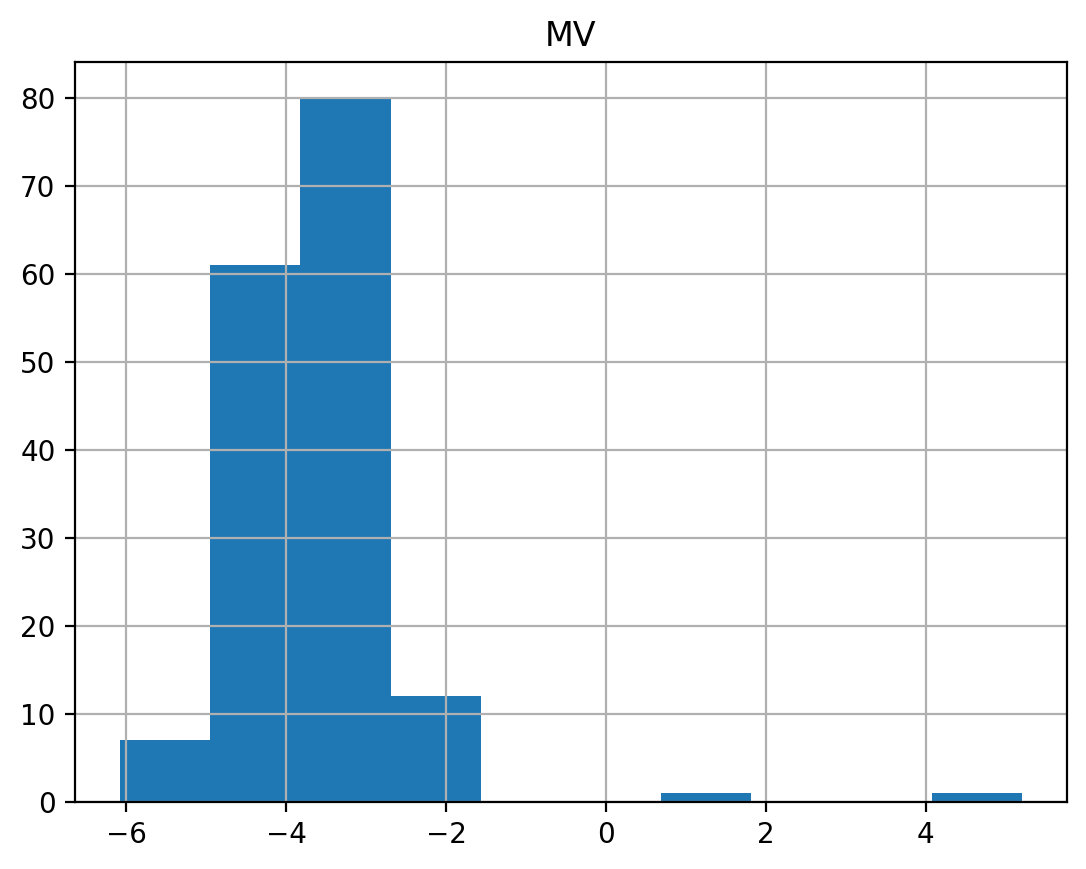

In [18]:
#Visual Inspection
df.hist('MV')


array([[<Axes: title={'center': 'LogP'}>]], dtype=object)

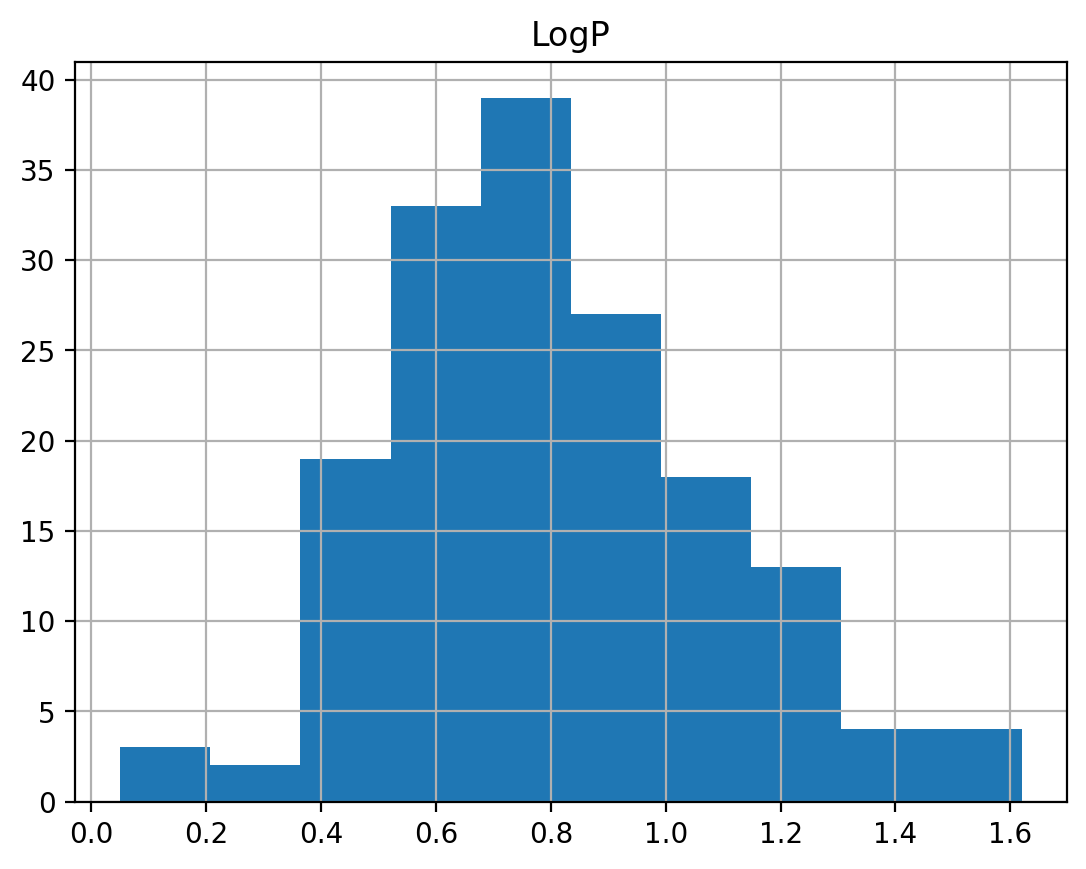

In [20]:
df.hist("LogP")

array([[<Axes: title={'center': 'MV_err'}>]], dtype=object)

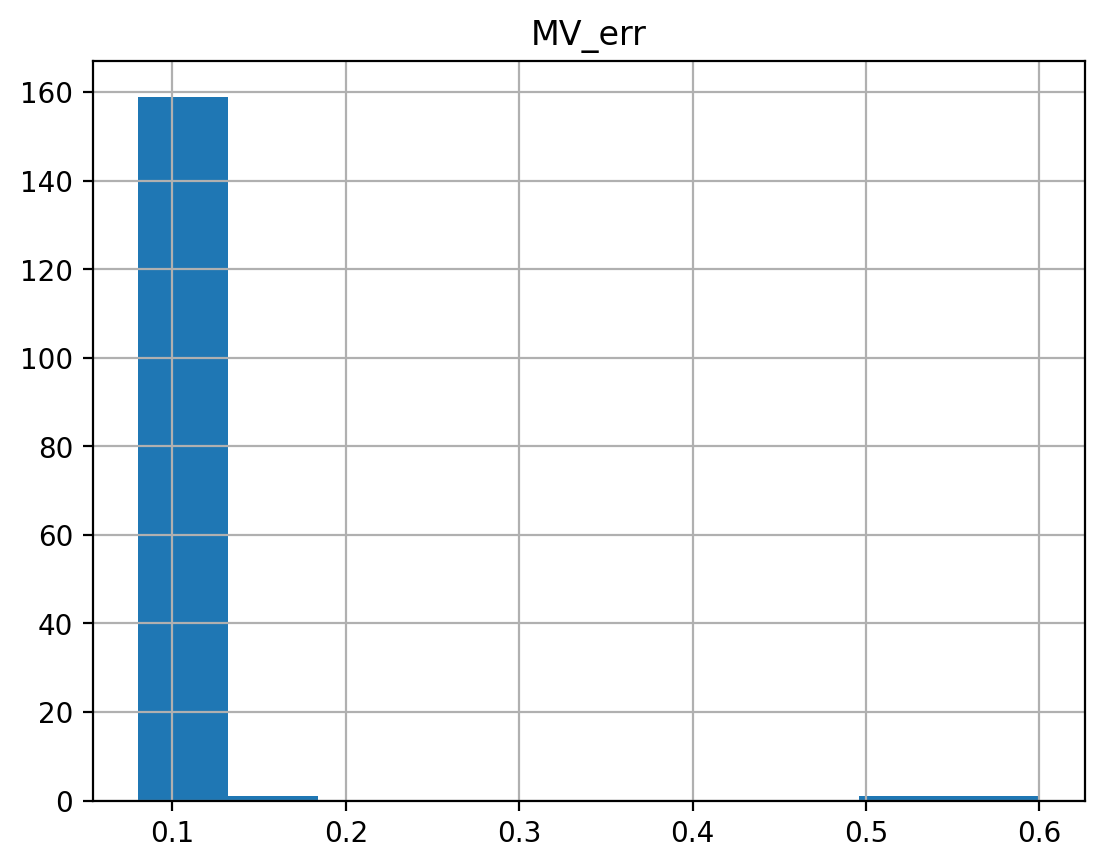

In [21]:
df.hist('MV_err')

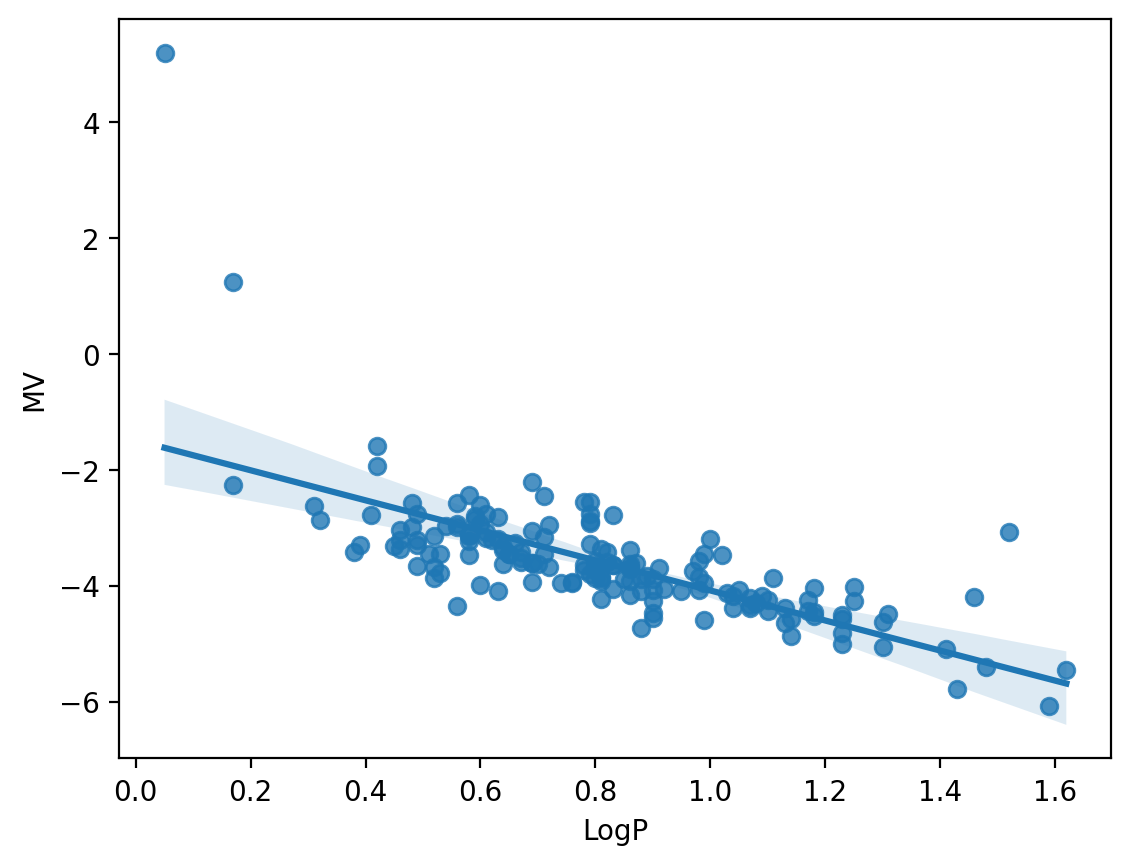

In [22]:
import seaborn as sns

regression = sns.regplot(data = df, x = df['LogP'], y = df['MV'])



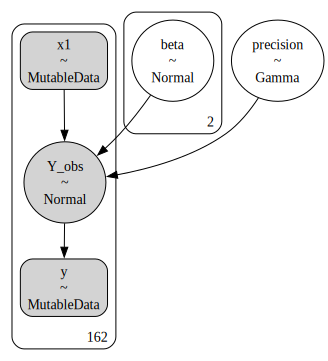

In [23]:
#linear model without error

from pymc import Model, Normal, Gamma, model_to_graphviz
# The following code implements the model in PyMC:

basic_model = Model() #<1>
with basic_model as basic: #<2>
    y=pm.MutableData(name='y',value =df['MV']) #<3> -- UNOBSERVED RV
    x1=pm.MutableData(name='x1',value =df['LogP'])
    # Priors for unknown model parameters -- PRIOR DISTRIBUTIONS
    beta = Normal('beta', mu=0, tau=1./10, shape=2) #<4>
    precision = Gamma('precision', alpha=1, beta=1)
    # Expected value of outcome
    mu =beta[0] + beta[1]*x1 
    # Likelihood (sampling distribution) of observations-- OBSERVED RV
    Y_obs = Normal('Y_obs', mu=mu, tau=precision, observed=y)
    
model_to_graphviz(basic)

In [24]:
# Draw sample
from pymc import find_MAP

%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

print(f"Running on PyMC v{pm.__version__}")
with basic:
    start = find_MAP() 
    # draw 2000 posterior samples
    trace = pm.sample(cores=4, chains=6, return_inferencedata=True)
trace

Running on PyMC v5.9.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [beta, precision]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 2 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [26]:
# first 5 values for lambda from 4 chains
trace.posterior["precision"].sel(draw=slice(0, 4))

<xarray.DataArray 'precision' (chain: 6, draw: 5)>
array([[1.466182  , 1.85705061, 1.66134519, 1.47673273, 1.43099603],
       [1.72552542, 1.68652401, 1.86837429, 1.61603864, 1.7311023 ],
       [1.62034032, 1.67357004, 1.64817957, 1.58934899, 1.71895847],
       [1.58010738, 1.58809046, 1.83187894, 1.85421356, 1.87736579],
       [1.73070113, 1.50310083, 1.9339197 , 1.68985748, 1.63900135],
       [1.80282903, 1.8244897 , 1.52229735, 1.61363461, 2.05811755]])
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5
  * draw     (draw) int64 0 1 2 3 4

In [27]:
posterior = trace.posterior
posterior

<xarray.Dataset>
Dimensions:     (chain: 6, draw: 1000, beta_dim_0: 2)
Coordinates:
  * chain       (chain) int64 0 1 2 3 4 5
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * beta_dim_0  (beta_dim_0) int64 0 1
Data variables:
    beta        (chain, draw, beta_dim_0) float64 -1.27 -2.814 ... -1.503 -2.663
    precision   (chain, draw) float64 1.466 1.857 1.661 ... 1.571 1.533 1.635
Attributes:
    created_at:                 2023-11-29T15:32:50.690724
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.9.0
    sampling_time:              1.8895599842071533
    tuning_steps:               1000

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'precision'}>,
        <Axes: title={'center': 'precision'}>]], dtype=object)

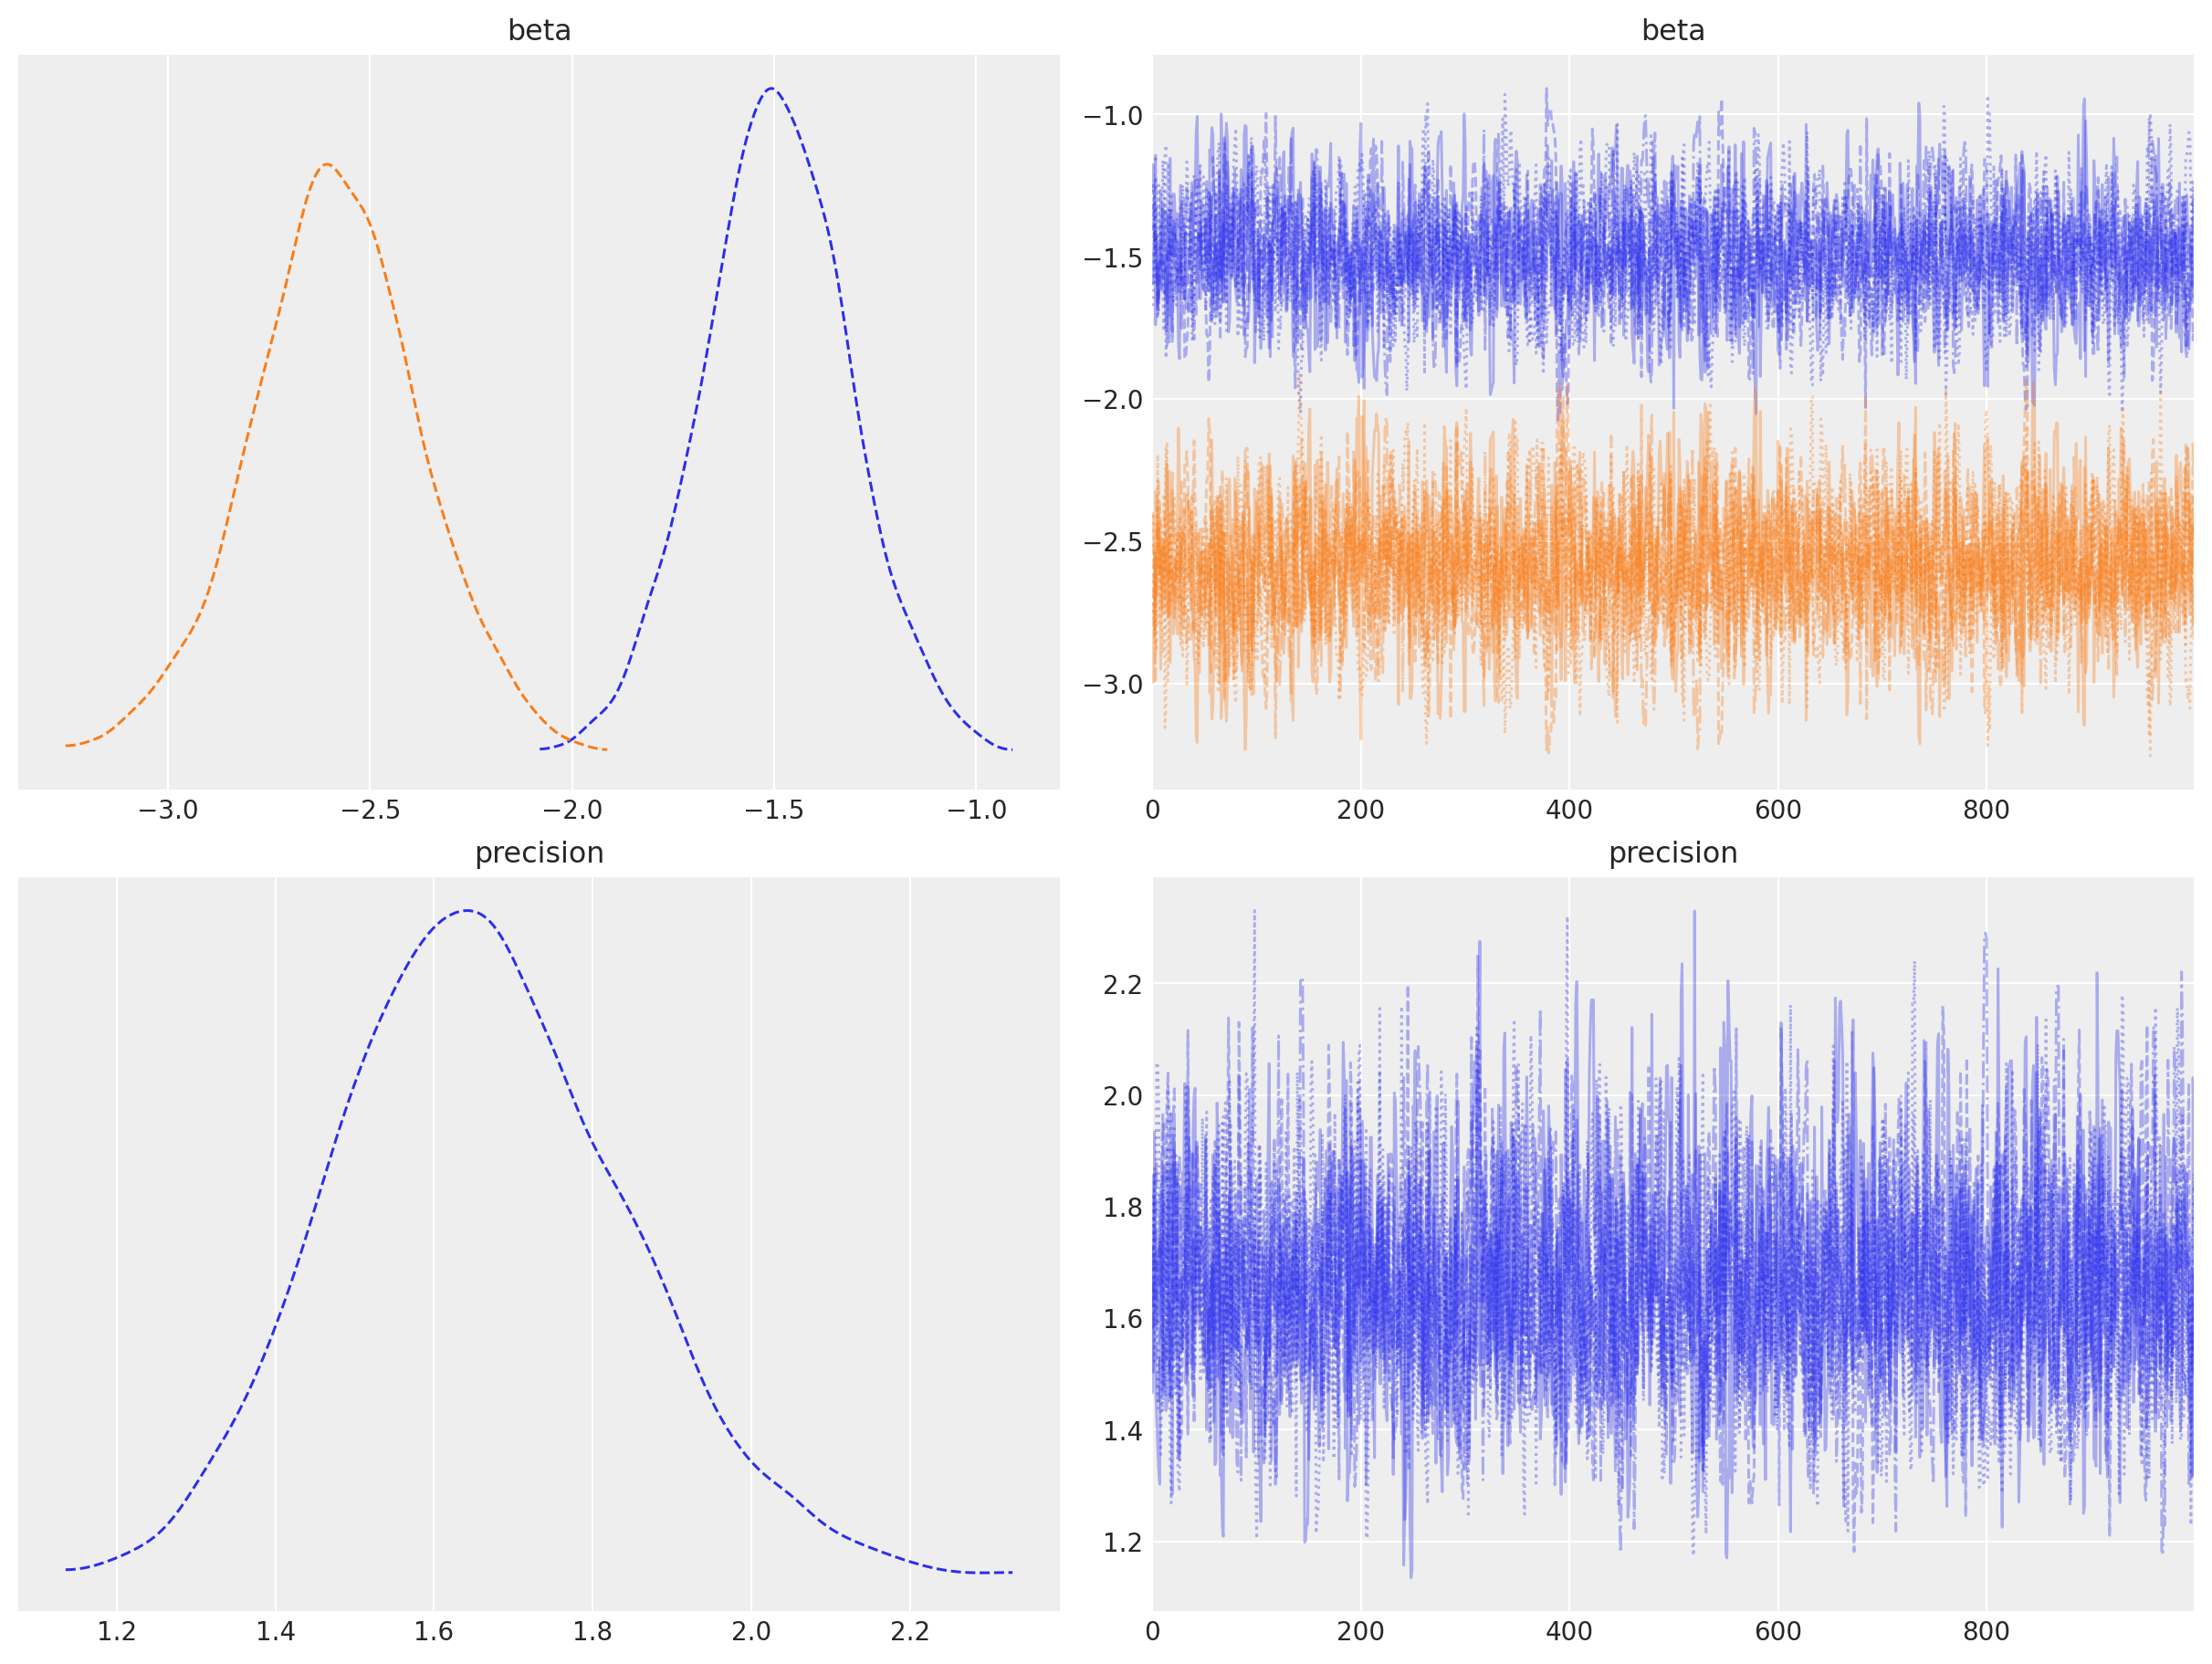

In [28]:
az.plot_trace(trace,combined=True,figsize=(12, 9))

In [29]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-1.493,0.182,-1.830,-1.137,0.004,0.003,2223.0,2452.0,1.0
beta[1],-2.586,0.211,-2.992,-2.176,0.004,0.003,2229.0,2259.0,1.0
precision,1.659,0.182,1.302,1.985,0.003,0.002,2799.0,2934.0,1.0


array([<Axes: title={'center': 'beta\n0'}>,
       <Axes: title={'center': 'beta\n1'}>,
       <Axes: title={'center': 'precision'}>], dtype=object)

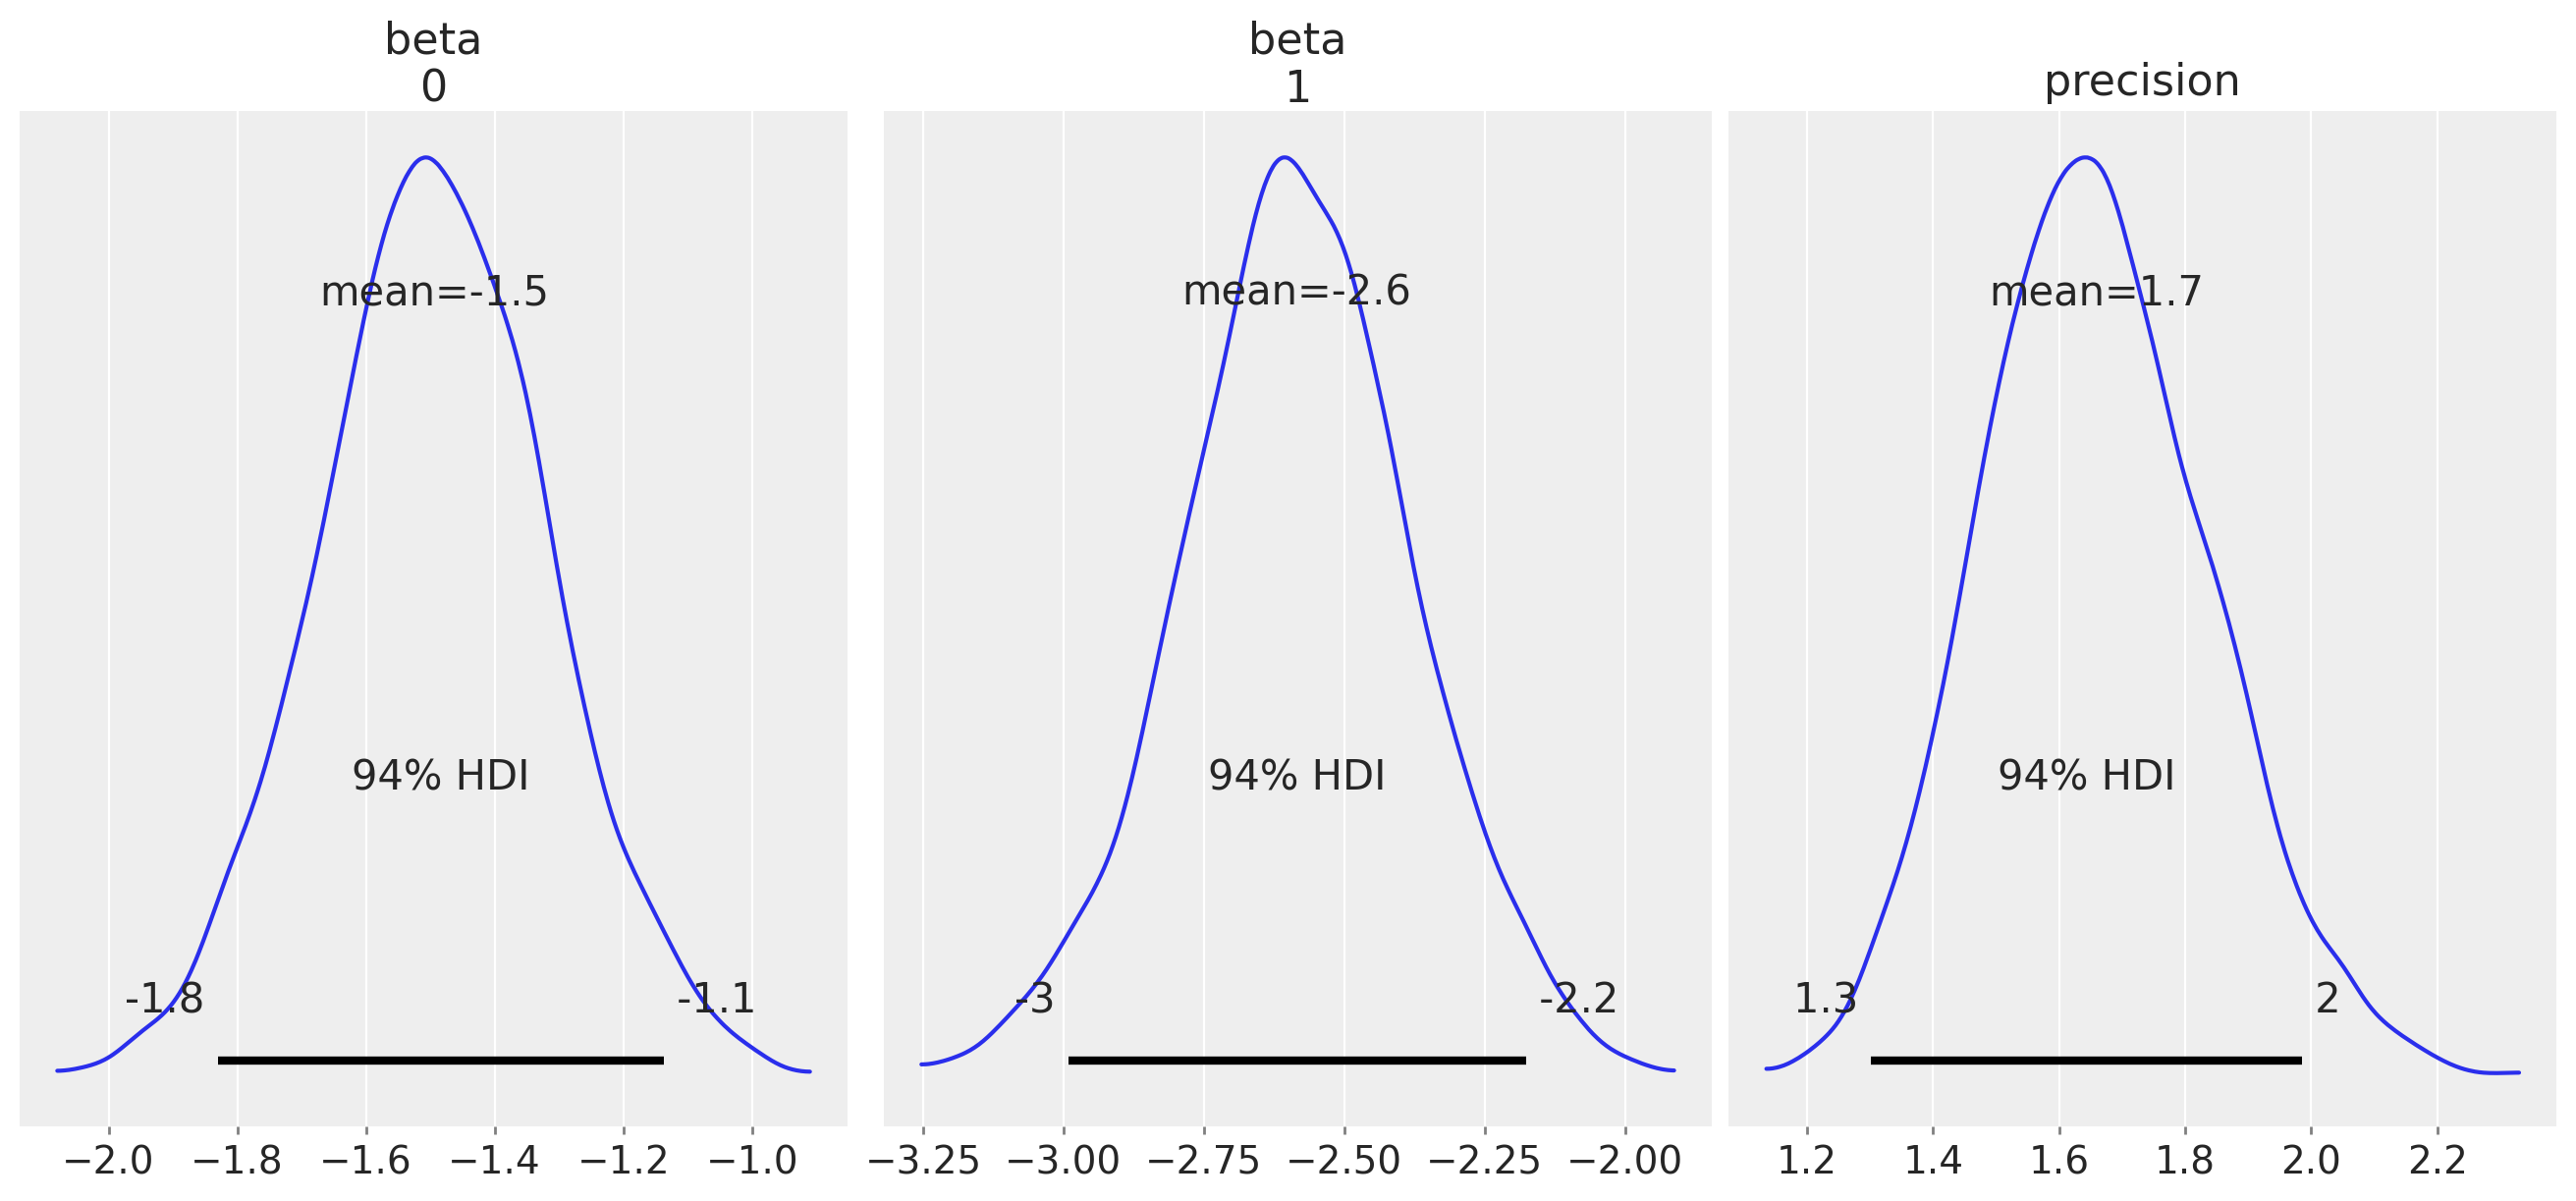

In [30]:
az.plot_posterior(trace,figsize=(13, 6))

In [31]:
#Estimate effective sample size
print(az.ess(trace,var_names=['precision']))

<xarray.Dataset>
Dimensions:    ()
Data variables:
    precision  float64 2.799e+03


array([<Axes: title={'center': 'beta\n0'}>,
       <Axes: title={'center': 'beta\n1'}>], dtype=object)

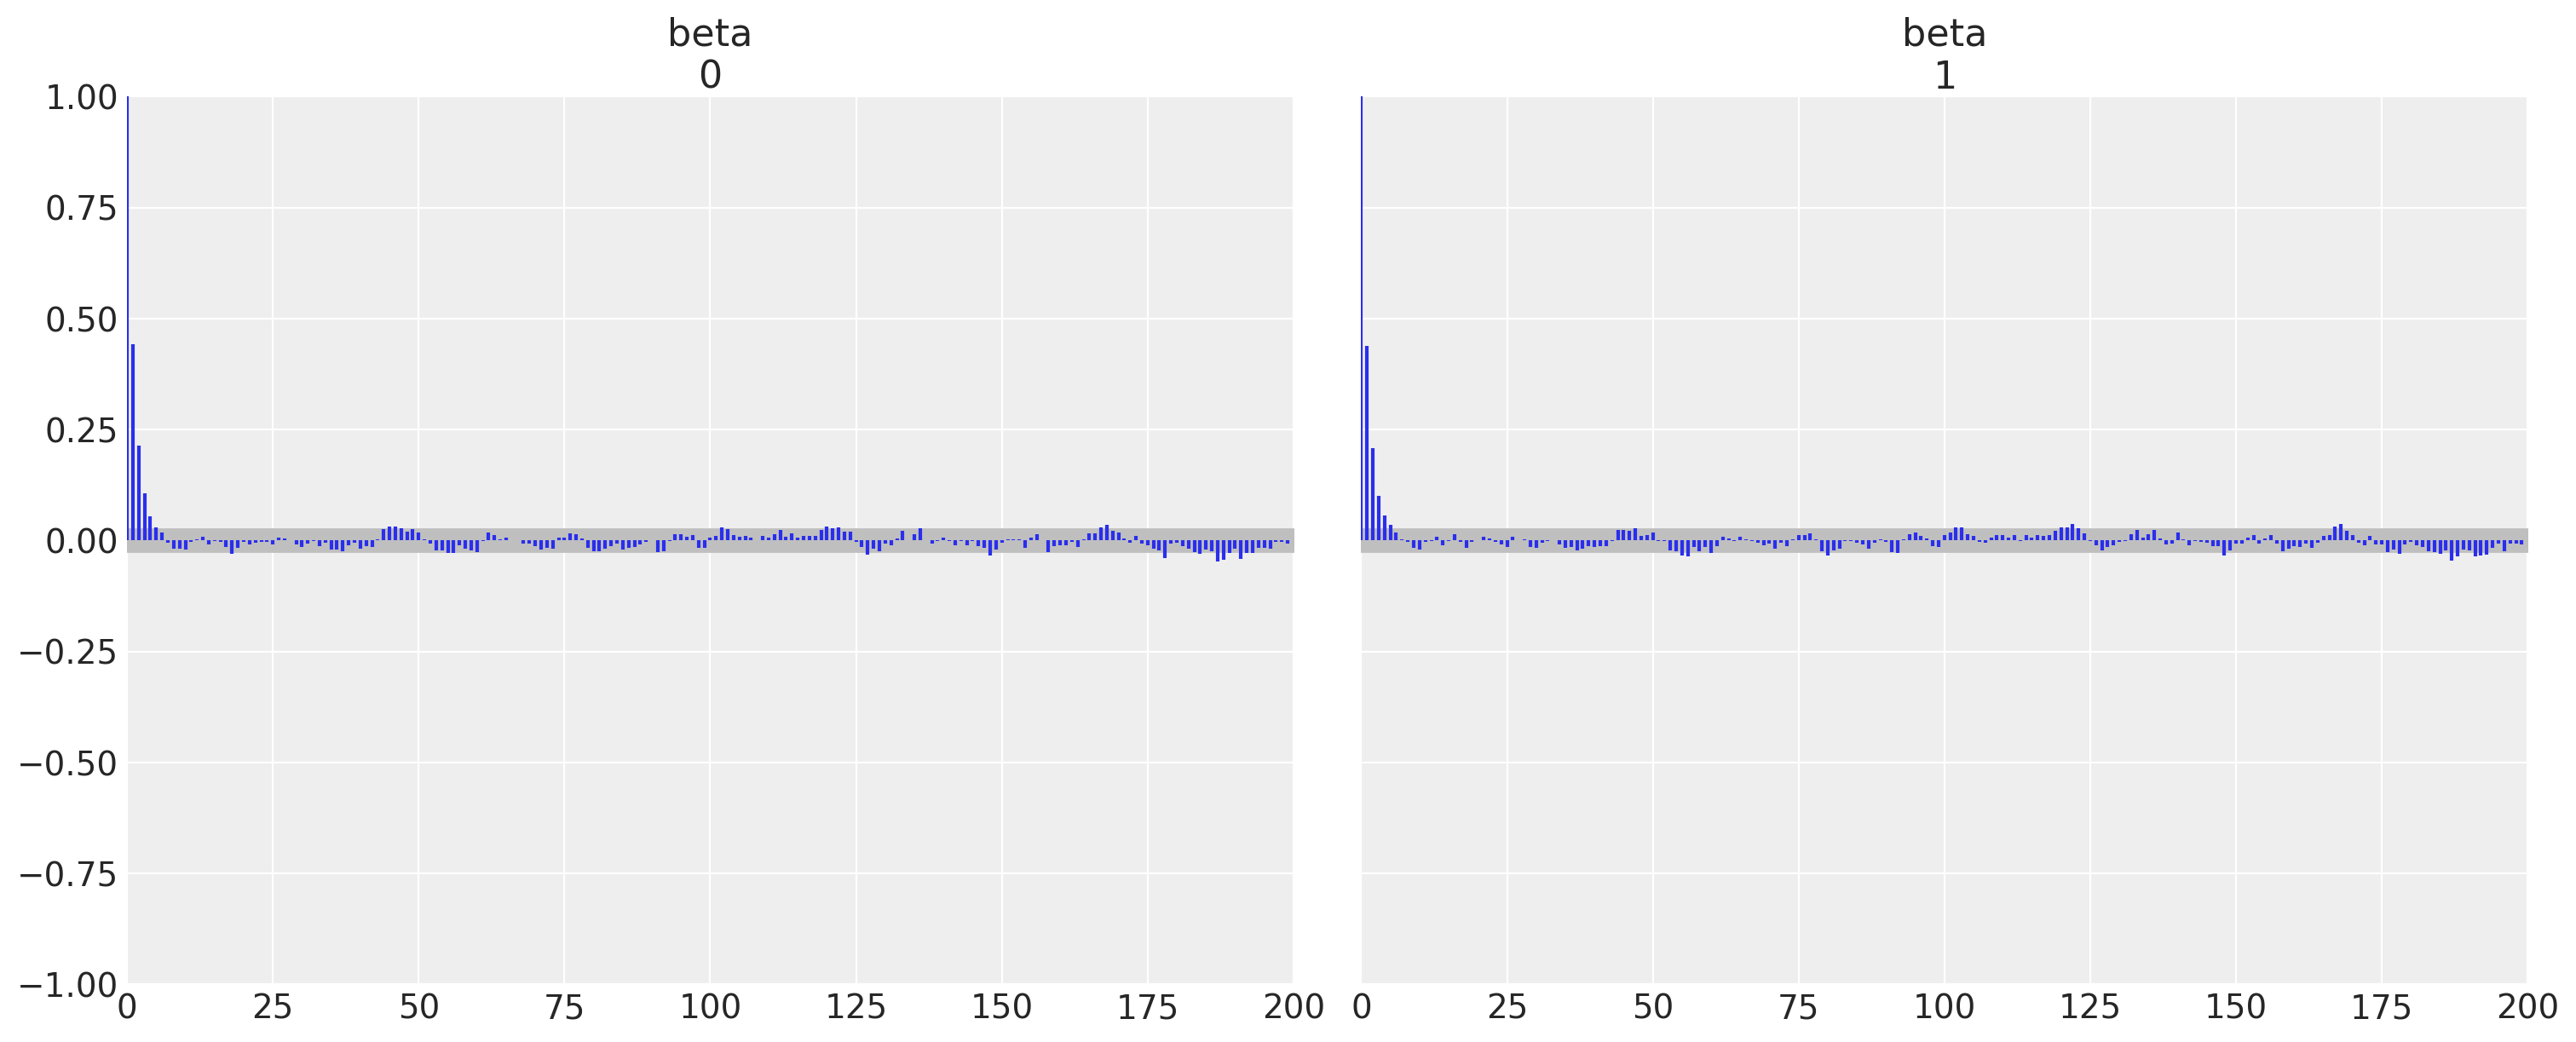

In [32]:
#AUtocorrelation plot

az.plot_autocorr(trace, var_names=['beta'], filter_vars="like",  max_lag=200,combined=True,figsize=(15, 6))



In [33]:
#Posterior predictive sampling

with basic_model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

trace.posterior_predictive

Sampling: [Y_obs]


<xarray.Dataset>
Dimensions:      (chain: 6, draw: 1000, Y_obs_dim_2: 162)
Coordinates:
  * chain        (chain) int64 0 1 2 3 4 5
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * Y_obs_dim_2  (Y_obs_dim_2) int64 0 1 2 3 4 5 6 ... 156 157 158 159 160 161
Data variables:
    Y_obs        (chain, draw, Y_obs_dim_2) float64 -2.023 -1.784 ... -5.834
Attributes:
    created_at:                 2023-11-29T15:34:20.533787
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.9.0

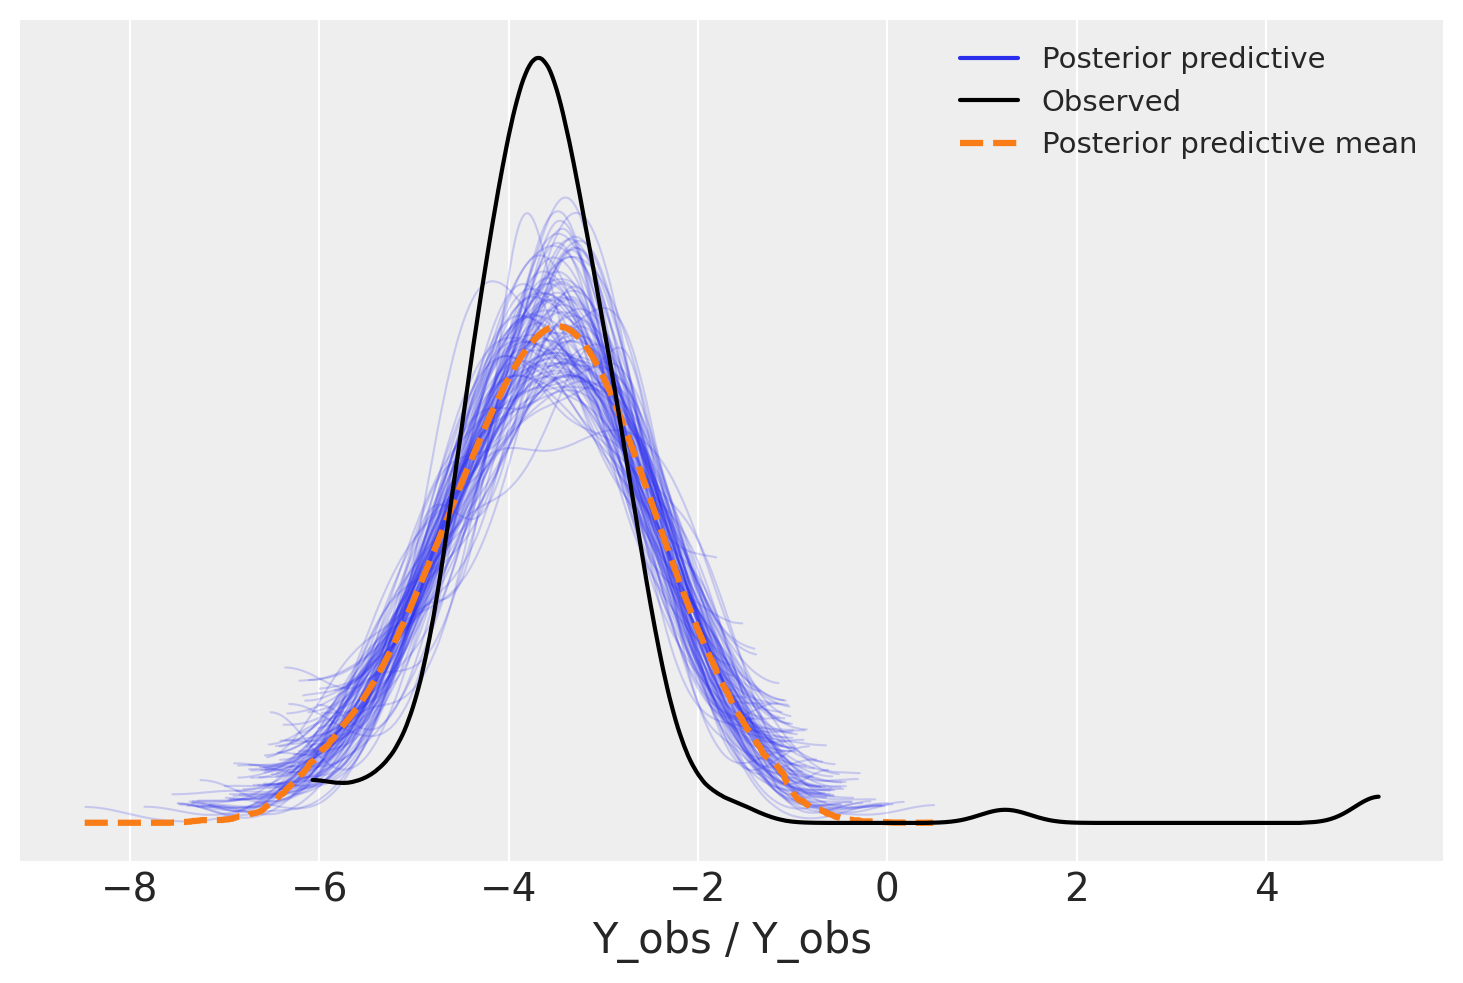

In [34]:
#PLot ppc
az.plot_ppc(trace, num_pp_samples=100);

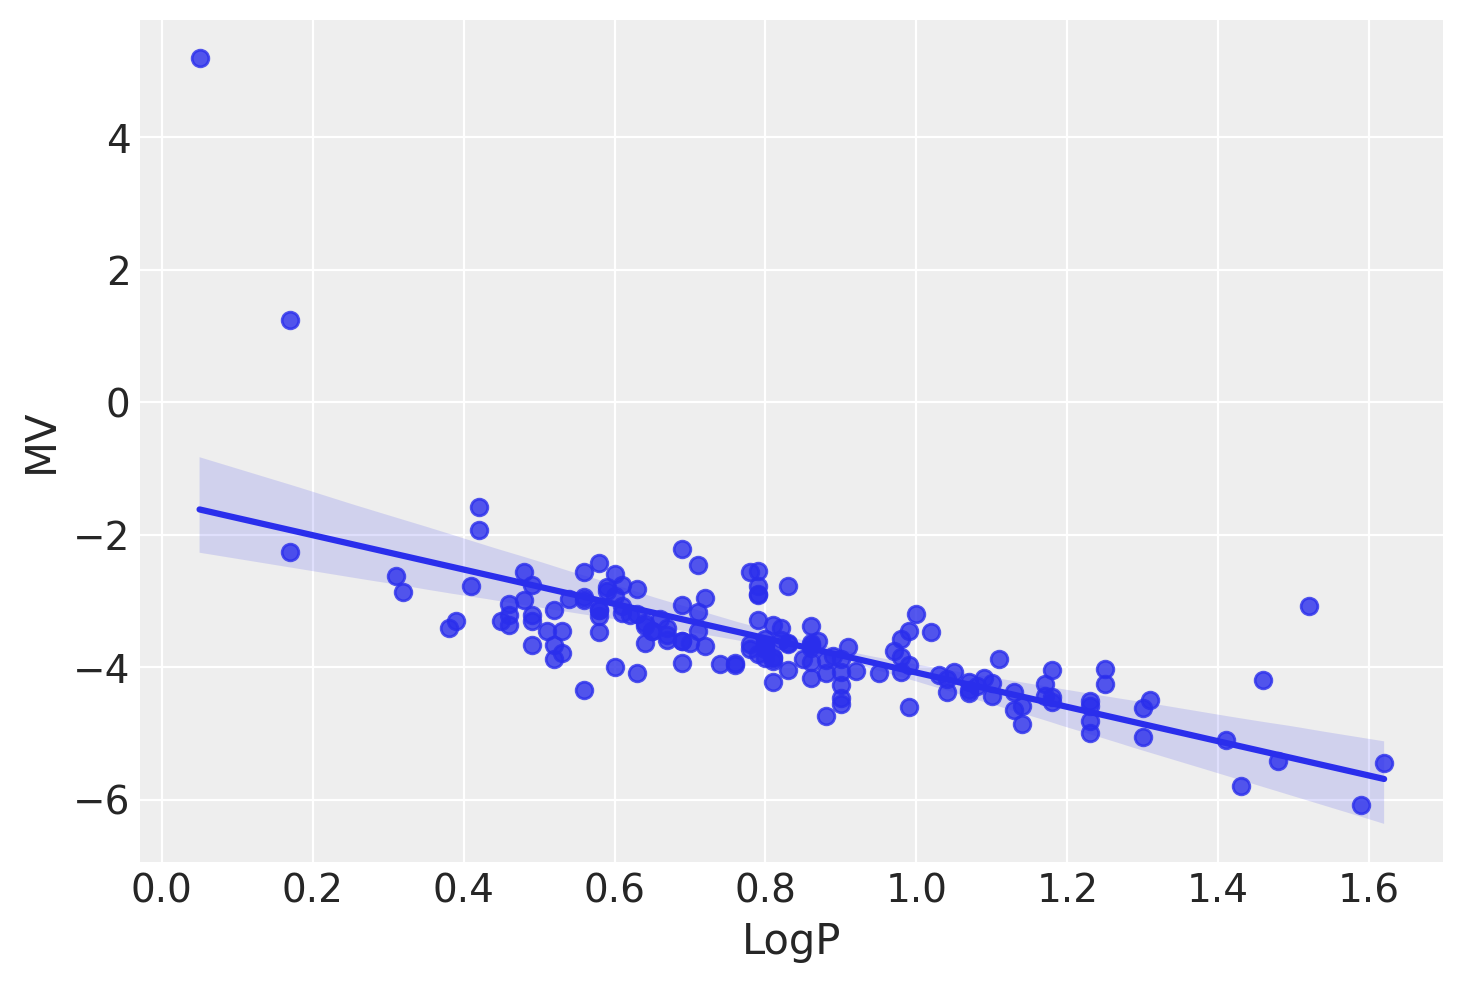

In [36]:
# Mixture model

with pm.Model() as mixture: #<2>
    
    y=pm.MutableData(name='y',value =df['MV']) #<3> -- UNOBSERVED RV
    x1=pm.MutableData(name='x1',value =df['LogP'])
    
    
    # Priors for unknown model parameters -- PRIOR DISTRIBUTIONS
    beta = Normal('beta', mu=0, tau=1./10, shape=2) #<4>
    precision = Gamma('precision', alpha=1, beta=1)
    
    
    # Expected value of outcome
    mu =beta[0] + beta[1]*x1 
    # Likelihood (sampling distribution) of observations-- OBSERVED RV
    Y_obs = Normal('Y_obs', mu=mu, tau=precision, observed=y)
    

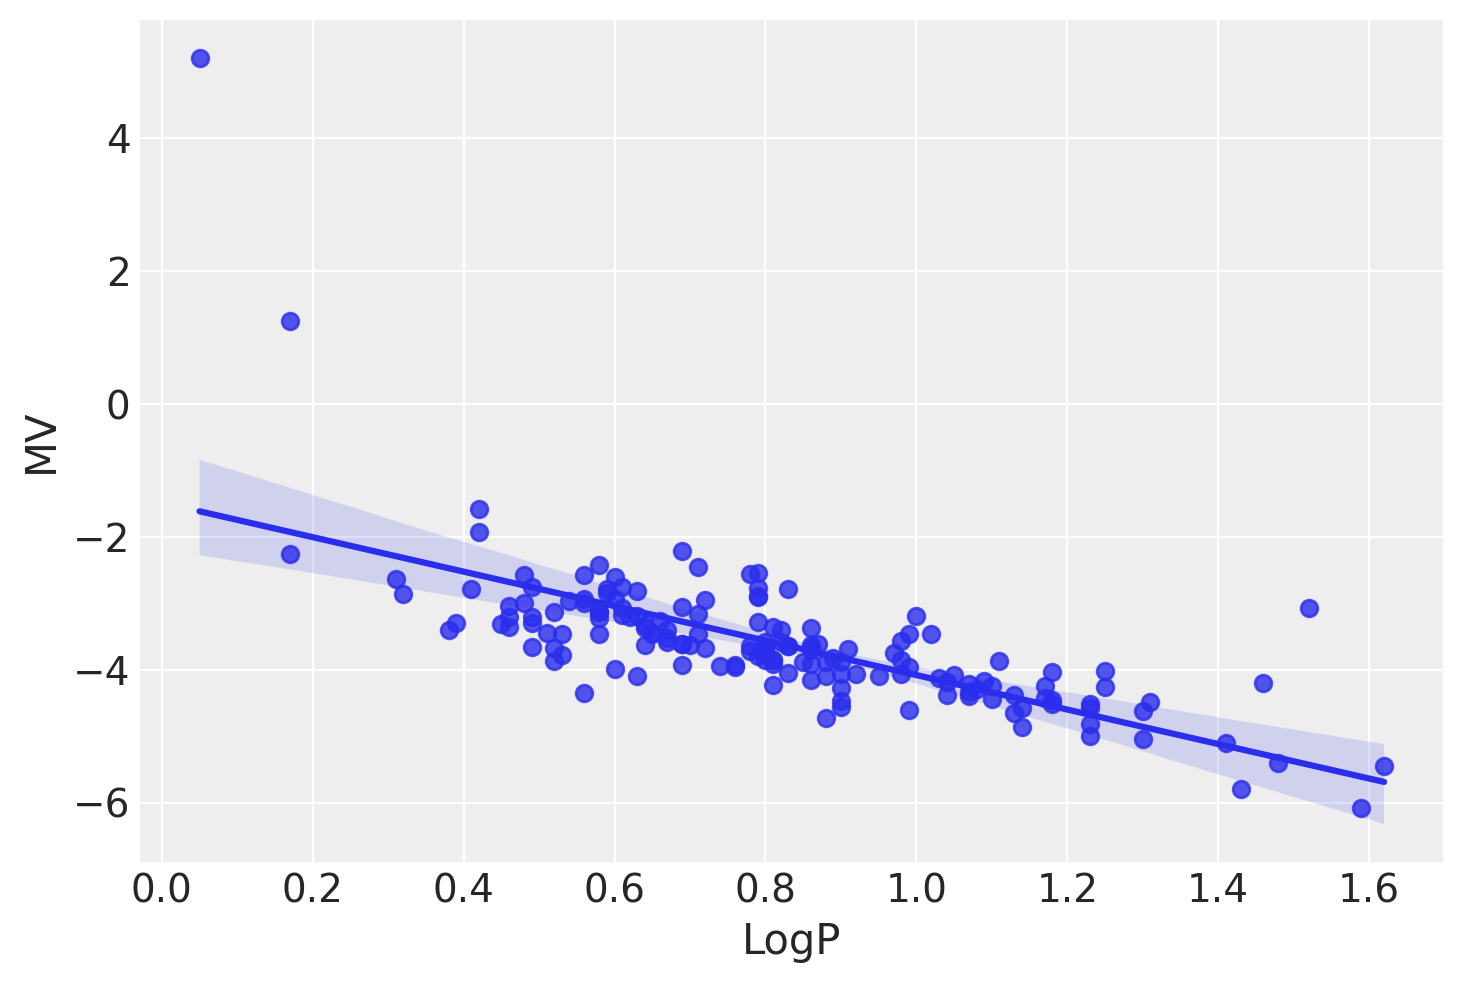

In [37]:
import seaborn as sns

regression = sns.regplot(data = df, x = df['LogP'], y = df['MV'])

